### Download metrics

In [29]:
import collections

import wandb
from tqdm.notebook import tqdm

metric_names = [
    "train/CrossEntropyLoss",
    "train/ZLoss",
    "optim/total_grad_norm",
    "optim/learning_rate_group0",
]

wandb_groups = [
    "peteish7",
    "peteish13-highlr",
]

group_to_tokens_per_step = {
    "peteish7": 1024 * 4096,
    "peteish13-highlr": 2048 * 4096
}

metrics = {
    (group, name): {}
    for name in metric_names
    for group in wandb_groups
}

api = wandb.Api(timeout=19)
wandb_project = "olmo-medium"
for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/{wandb_project}", filters={"group": wandb_group}, order="created_at")
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + metric_names, page_size=10000):
            step = int(data["_step"])
            for metric_name in metric_names:
                value = data[metric_name]
                if value is not None:
                    metrics[(wandb_group, metric_name)][step] = data[metric_name]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


### Order metrics

In [30]:
metrics = {
    name: dict(
        sorted(values.items())
    )
    for name, values in metrics.items()
}

### Health of the run

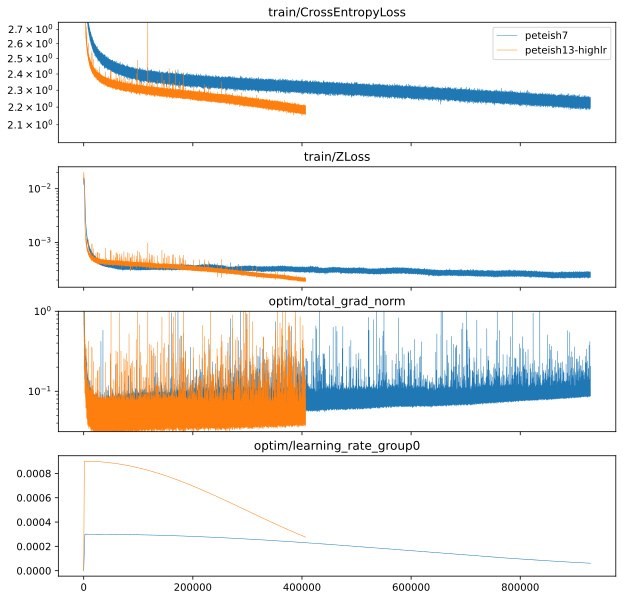

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

MAX_STEP = None

fig, axs = plt.subplots(len(metric_names), sharex=True, figsize=(10, 10))
for metric_name, ax in zip(metric_names, axs):
    ax.set_title(metric_name)
    group_to_values = {}
    group_to_steps = {}
    for (group_name, inner_metric_name), values in metrics.items():
        if inner_metric_name != metric_name:
            continue
        steps = list(values.keys())
        values = list(values.values())

        i = None        
        try:
            i = steps.index(MAX_STEP)
        except ValueError:
            pass
        if i is not None:
            steps = steps[:i+1]
            values = values[:i+1]
        
        group_to_values[group_name] = values
        group_to_steps[group_name] = steps
        ax.plot(steps, values, linewidth=0.5, label=group_name)
        if "learning_rate" not in metric_name:
            ax.set_yscale("log")
        if "CrossEntropyLoss" in metric_name:
            ax.set_ylim([None, 2.75])
        if "total_grad_norm" in metric_name:
            ax.set_ylim([None, 1.0])
    if ax == axs[0]:
        ax.legend()
    

### Downstream Metrics

In [32]:
aggregate_metric_definitions = {
    "MMLU 5-shot MC": {
        "eval/downstream/mmlu_stem_mc_5shot_len_norm": 0.215,
        "eval/downstream/mmlu_humanities_mc_5shot_len_norm": 0.335,
        "eval/downstream/mmlu_social_sciences_mc_5shot_len_norm": 0.219,
        "eval/downstream/mmlu_other_mc_5shot_len_norm": 0.231
    },
    "Average of core 12": {
        "eval/downstream/arc_challenge_len_norm": 1 / 12,
        "eval/downstream/arc_easy_acc": 1 / 12,
        "eval/downstream/basic_arithmetic_acc": 1 / 12,
        "eval/downstream/boolq_acc": 1 / 12,
        "eval/downstream/commonsense_qa_len_norm": 1 / 12,
        "eval/downstream/copa_acc": 1 / 12,
        "eval/downstream/hellaswag_len_norm": 1 / 12,
        "eval/downstream/openbook_qa_len_norm": 1 / 12,
        "eval/downstream/piqa_len_norm": 1 / 12,
        "eval/downstream/sciq_acc": 1 / 12,
        "eval/downstream/social_iqa_len_norm": 1 / 12,
        "eval/downstream/winogrande_acc": 1 / 12,
    },
    "Hellaswag": {
        "eval/downstream/hellaswag_len_norm": 1
    }
}
aggregate_metric_names = list(aggregate_metric_definitions.keys())

downstream_metric_names = set()
for downstream_metrics in aggregate_metric_definitions.values():
    downstream_metric_names.update(downstream_metrics.keys())
downstream_metric_names = list(downstream_metric_names)
downstream_metric_names.sort()
downstream_metrics = {
    (group, name): {}
    for name in downstream_metric_names
    for group in wandb_groups
}

for wandb_group in wandb_groups:
    runs = api.runs(f"ai2-llm/{wandb_project}", filters={"group": wandb_group}, order="created_at")
    for run in tqdm(runs):
        for data in run.scan_history(keys=["_step"] + downstream_metric_names, page_size=10000):
            step = int(data["_step"])
            for downstream_metric_name in downstream_metric_names:
                value = data[downstream_metric_name]
                if value is not None:
                    downstream_metrics[(wandb_group, downstream_metric_name)][step] = data[downstream_metric_name]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


In [33]:
downstream_metrics = {
    name: dict(
        sorted(values.items())
    )
    for name, values in downstream_metrics.items()
}

In [34]:
# actually perform the aggregations
import collections

aggregate_metrics = {
    (group, name): {}
    for name in aggregate_metric_definitions.keys()
    for group in wandb_groups
}

for wandb_group in wandb_groups:
    for aggregate_metric_name, aggregate_metric_definition in aggregate_metric_definitions.items():
        values = collections.defaultdict(lambda: 0.0)
        step_to_seen = collections.Counter()
        for downstream_metric_name, weight in aggregate_metric_definition.items():
            for step, value in downstream_metrics[(wandb_group, downstream_metric_name)].items():
                step_to_seen[step] += 1
                values[step] += weight * value
        assert all(times_seen == len(aggregate_metric_definition) for times_seen in step_to_seen.values())
        aggregate_metrics[(wandb_group, aggregate_metric_name)] = values

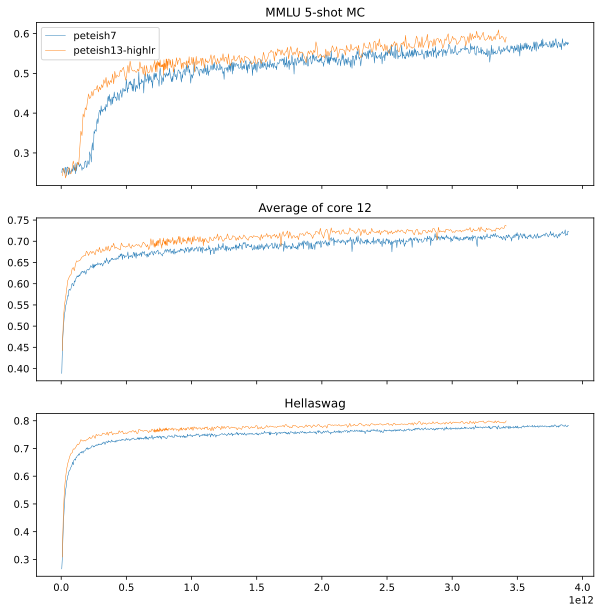

In [35]:
MAX_TOKENS = None

import math
NUM_COLS = 1
fig, axs = plt.subplots(
    math.ceil(len(aggregate_metric_names) / NUM_COLS),
    NUM_COLS,
    sharex=True,
    figsize=(10, 10),
    squeeze=False)
for i, metric_name in enumerate(aggregate_metric_names):
    ax = axs[i // NUM_COLS, i % NUM_COLS]
    ax.set_title(metric_name)
    for (group_name, inner_metric_name), values in aggregate_metrics.items():
        if inner_metric_name != metric_name:
            continue
        tokens = [s * group_to_tokens_per_step[group_name] for s in values.keys()]
        values = list(values.values())

        # TODO: This only works if you hit a number of tokens exactly.
        if MAX_TOKENS is not None:
            i = None
            try:
                i = tokens.index(MAX_TOKENS)
            except ValueError:
                pass
            if i is not None:
                tokens = tokens[:i+1]
                values = values[:i+1]

        ax.plot(tokens, values, linewidth=0.5, label=group_name)
    if ax == axs[0][0]:
        ax.legend()
